# Tensor Hypercontraction

SELECT and PREPARE for the second quantized Tensor Hypercontracted (THC) chemistry Hamtiltonian.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran.drawing import show_bloq, show_call_graph
from typing import *
import numpy as np

## `UniformSuperpositionTHC`
Prepare uniform superposition state for THC.

$$
    |0\rangle^{\otimes 2\log(M+1)} \rightarrow \sum_{\mu\le\nu}^{M} |\mu\rangle|\nu\rangle
    + \sum_{\mu}^{N/2}|\mu\rangle|\nu=M+1\rangle,
$$

where $M$ is the THC auxiliary dimension, and $N$ is the number of spin orbitals.

The toffoli complexity of this gate should be $10 \log(M+1) + 2 b_r - 9$.
Currently it is a good deal larger due to:
 1. inverting inequality tests should not need more toffolis.
 2. We are not using phase-gradient gate toffoli cost for Ry rotations
 3. Small differences in quoted vs implemented comparator costs.

See: https://github.com/quantumlib/Qualtran/issues/390

#### Parameters
 - `num_mu`: THC auxiliary index dimension $M$
 - `num_spin_orb`: number of spin orbitals $N$ 

#### Registers
 - `mu`: $\mu$ register.
 - `nu`: $\nu$ register.
 - `succ`: ancilla flagging success of amplitude amplification.
 - `eq_nu_mp1`: ancillas for flagging if $\nu = M+1$. 

#### References
[Even more efficient quantum computations of chemistry through tensor hypercontraction](https://arxiv.org/pdf/2011.03494.pdf). Eq. 29.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


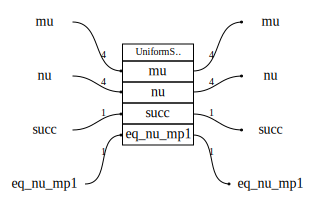

In [2]:
from qualtran.bloqs.chemistry.thc import UniformSuperpositionTHC

num_mu = 10
num_spin_orb = 4
bloq = UniformSuperpositionTHC(num_mu=num_mu, num_spin_orb=num_spin_orb)
show_bloq(bloq)

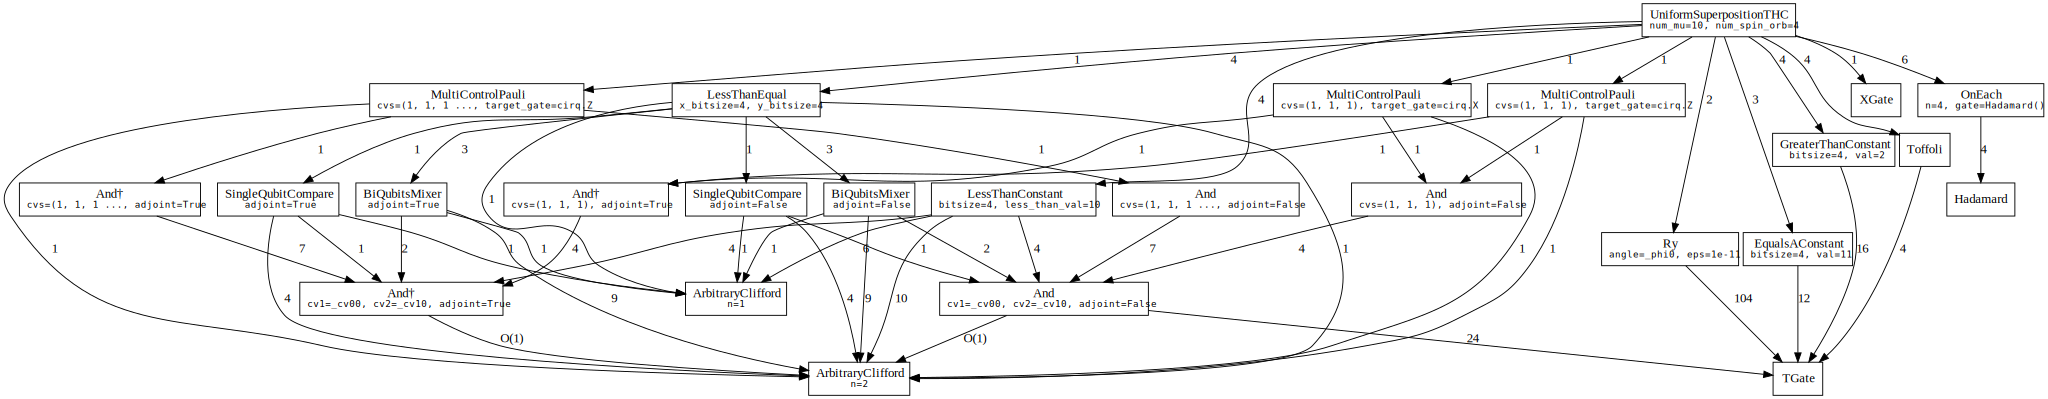

In [3]:
from qualtran.bloqs.chemistry.thc.notebook_utils import generalize

graph, sigma = bloq.call_graph(generalizer=generalize)
show_call_graph(graph)

Let's print out the costs contributing to the TCount.

In [4]:
from qualtran.bloqs.chemistry.thc.notebook_utils import bin_bloq_counts

binned_counts = bin_bloq_counts(bloq)
# number of bits for mu register (nm in THC paper)
# note this register should range up to num_mu + 1, not num_mu, hence it's just bit_length not (num_mu - 1).bit_length()
nm = bloq.num_mu.bit_length()
# Costs for THC paper
# The factor of 4 is for Toffoli -> T conversion
paper_costs = {
    'comparator': 4*(4*(nm - 1) + (4*nm - 3)), # 4 comparitors of cost nm - 1 Toffolis
    'rotation': 4*(4 + 4), # Given as br - 3, br = 7 is the number of bits of precision for rotations.
    'reflections': 4*(3 + 2*nm-1), # 5 qubit reflection for comparitors and 2*nm + 1 qubits reflect after hadamards
    'other': 4*3, # "Checking the inequality test" unclear if this is the multi-control not gate.
}
for k, v in paper_costs.items():
    print(f"{k+':':15s} qualtran = {binned_counts[k]:5d} vs paper cost = {v:5d}.")

comparator:     qualtran =   276 vs paper cost =   100.
rotation:       qualtran =   104 vs paper cost =    32.
reflections:    qualtran =    36 vs paper cost =    40.
other:          qualtran =    16 vs paper cost =    12.


The discrepancies arise from the following issues:

1. Comparators: The paper uncomputes the comparators at zero Toffoli cost, whereas we do not. This is nearly a factor of two difference. This leaves us with 144 vs 100. The extra factor of 44 arises from the different costs of the comparators listed in the paper and those in qualtran. The paper uses a cost of $n_m - 1$ for all the comparitors (with the final $\nu = M+1$ equality test costing $n_m$), whereas the qualtran comparators assume a cost of $n_m - 1$ for equality testing to a classical value, $n_m$ for comparison to a classical value and $2 n_m - 1$ when comparing two quantum registers.
2. Rotations: The paper uses a phase gradient register which has a much lower cost than the qualtran cost which assumes a generic synthesis cost. 
3. Reflections and other: This discrepancy arises because the paper states the first reflection in between the comparators has Toffoli cost of 3, rather than what we have which is 2 Toffolis and 1 Multi-Controlled Z which costs 2 Toffolis. Our costs for the second reflection match. The other discrepancy is for the operations in between the second set of comparators. Here we count 2 Toffolis and 1 Multi-Controlled-Not gate of cost 2 Toffolis.  

The leading order Toffoli cost of this state preparation is 10 $n_m$ in the paper which arises from the comparators and the reflection on the $\mu$ and $\nu$ registers, i.e. $4(n_m - 1) + 4n_m - 3 + 2n_m -1 \approx 10 n_m$.

## `PrepareTHC`
State Preparation for THC Hamilontian.

Prepares the state

$$
    \frac{1}{\sqrt{\lambda}}|+\rangle|+\rangle\left[
        \sum_\ell^{N/2} \sqrt{t_\ell}|\ell\rangle|M+1\rangle
        + \frac{1}{\sqrt{2}} \sum_{\mu\le\nu}^M \sqrt{\zeta_{\mu\nu}} |\mu\rangle|\nu\rangle
    \right].
$$

Note we use UniformSuperpositionTHC as a subroutine as part of this bloq in
contrast to the reference which keeps them separate.

#### Parameters
 - `num_mu`: THC auxiliary index dimension $M$
 - `num_spin_orb`: number of spin orbitals $N$
 - `alt_mu`: Alternate values for mu indices.
 - `alt_nu`: Alternate values for nu indices.
 - `alt_theta`: Alternate values for theta indices.
 - `theta`: Signs of lcu coefficients.
 - `keep`: keep values.
 - `keep_bitsize`: number of bits for keep register for coherent alias sampling. 

#### Registers
 - `mu`: $\mu$ register.
 - `nu`: $\nu$ register.
 - `theta`: sign register.
 - `succ`: success flag qubit from uniform state preparation
 - `eq_nu_mp1`: flag for if $nu = M+1$
 - `plus_a / plus_b`: plus state for controlled swaps on spins. 

#### References
[Even more efficient quantum computations of chemistry through tensor hypercontraction](https://arxiv.org/pdf/2011.03494.pdf) Fig. 2 and Fig. 3.


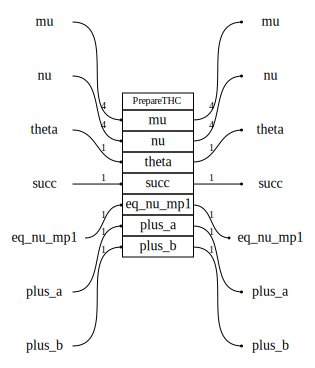

In [5]:
from qualtran.bloqs.chemistry.thc import PrepareTHC

num_spat = 4
num_mu = 8
t_l = np.random.normal(0, 1, size=num_spat)
zeta = np.random.normal(0, 1, size=(num_mu, num_mu))
zeta = 0.5 * (zeta + zeta.T)
eps = 1e-3
bloq = PrepareTHC.from_hamiltonian_coeffs(t_l, zeta, probability_epsilon=eps)
show_bloq(bloq)

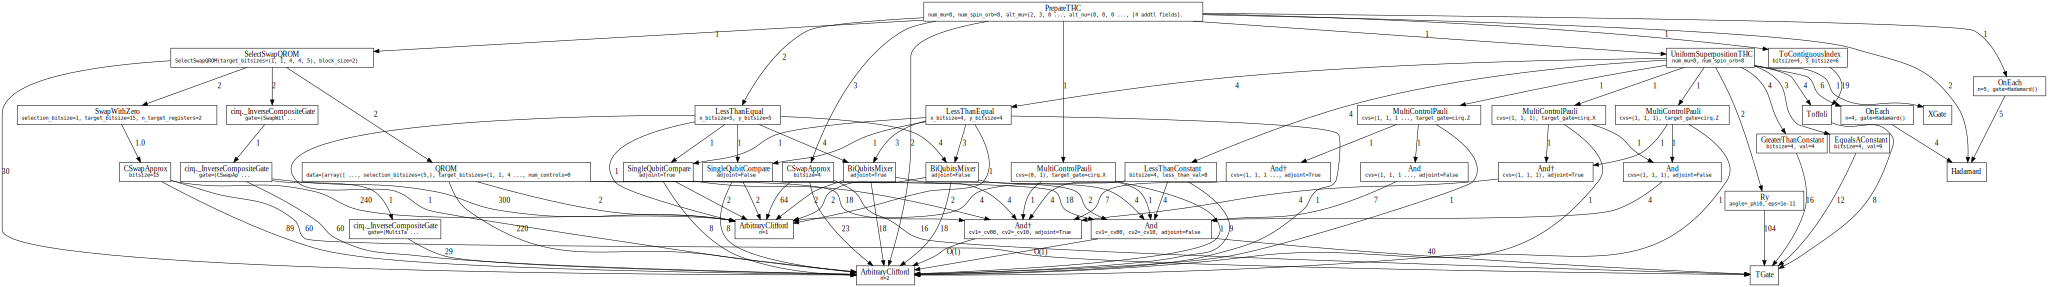

In [6]:
graph, sigma = bloq.call_graph(generalizer=generalize)
show_call_graph(graph)

### Paper Comparison

Let's compare our costs to those from the paper. Note we will only look at the cost of prepare. Inverting prepare has the same cost up to the cost of the inverse QROM being reduced to

$$
\lceil \frac{d}{k_{s2}} \rceil + k_{s2}
$$


In [7]:
from qualtran.bloqs.chemistry.thc.notebook_utils import bin_bloq_counts

binned_counts = bin_bloq_counts(bloq)
data_size = bloq.num_mu * (bloq.num_mu + 1) // 2 + bloq.num_spin_orb // 2

num_bits_mu = bloq.num_mu.bit_length() 
qrom_bitsize = 2 * num_bits_mu + 2 + bloq.keep_bitsize
paper_costs = {
    'contiguous_register': 4*(num_bits_mu ** 2 + num_bits_mu - 1),
    'controlled_swaps': 4*(2 * num_bits_mu + (num_bits_mu + 1)), # Swaps from inequality and swap from from 
    'qrom': 4 * (int(np.ceil(data_size/4) + qrom_bitsize * (4 - 1))), # Eq. 31 from THC paper, k = 4 in this specific case.
    'comparator': 4*bloq.keep_bitsize,
}
for k, v in paper_costs.items():
    print(f"{k+':':20s} qualtran = {binned_counts[k]:5d} vs paper cost = {v:5d}.")


print(f"Total cost = {sum(v for v in binned_counts.values())}")

contiguous_register: qualtran =    76 vs paper cost =    76.
controlled_swaps:    qualtran =    48 vs paper cost =    52.
qrom:                qualtran =   264 vs paper cost =   220.
comparator:          qualtran =    72 vs paper cost =    20.
Total cost = 900


The main discrepancies arise from QROAM assumptions and the difference in comparator cost seen before. 

## `SelectTHC`
SELECT for THC Hamilontian.

#### Parameters
 - `num_mu`: THC auxiliary index dimension $M$
 - `num_spin_orb`: number of spin orbitals $N$
 - `angles`: list of num_mu + num_spin_orb / 2 lists of rotation angles each of length num_spin_orb//2. Each rotation angle should be a `num_bits_theta` fixed point approximation to the angle. 

#### Registers
 - `mu`: $\mu$ register.
 - `nu`: $\nu$ register.
 - `theta`: sign register.
 - `succ`: success flag qubit from uniform state preparation
 - `eq_nu_mp1`: flag for if $nu = M+1$
 - `plus_a / plus_b`: plus state for controlled swaps on spins.
 - `sys_a / sys_b`: System registers for (a)lpha/(b)eta orbitals. 

#### References
[Even more efficient quantum computations of chemistry through tensor hypercontraction](https://arxiv.org/pdf/2011.03494.pdf) Fig. 7.


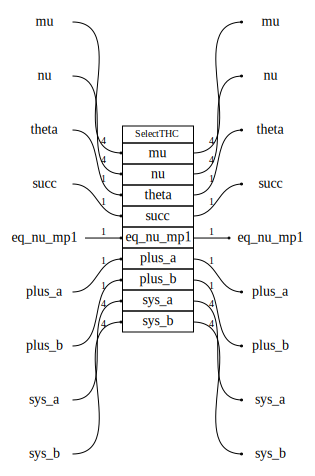

In [8]:
from qualtran.bloqs.chemistry.thc import SelectTHC

num_spat = 4
num_mu = 8
num_mu = 10
num_spin_orb = 2 * 4
angles = ((0.5,) * (num_spin_orb // 2),) * num_mu
select = SelectTHC(
    num_mu=num_mu, num_spin_orb=num_spin_orb, rotation_angles=angles, num_bits_theta=12
)
bloq = select
show_bloq(bloq)